# Hipothesis 2
The prices of houses tend to be higher in the summer months.

To tackle this statement, we will calculate the avg_prices of the houses depending on the zipcodes and the months of the year. We will investigate the case of high cost houses in comparison to lower cost houses and try to see the best months to buy or sell.

In [17]:
import pandas as pd
import sys
import missingno as msno
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from haversine import haversine, Unit

from optional.data_processing import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


df_all_housing_info = pd.read_csv('data/eda.csv')
df_all_housing_info.isna().sum()
#type(df_all_housing_info['date'][2])

df_all_housing_info.head(1)


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.0,1.0,1180.0,5650.0,1.0,NaN,0.0,3,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0


First we will drop the unnecessary data.

In [18]:
df_all_housing_info.drop(columns=['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15'])

,id,zipcode,date,price
0,7129300520,98178,2014-10-13,221900.0
1,6414100192,98125,2014-12-09,538000.0
2,5631500400,98028,2015-02-25,180000.0
3,2487200875,98136,2014-12-09,604000.0
4,1954400510,98074,2015-02-18,510000.0
...,...,...,...,...
21592,263000018,98103,2014-05-21,360000.0
21593,6600060120,98146,2015-02-23,400000.0
21594,1523300141,98144,2014-06-23,402101.0
21595,291310100,98027,2015-01-16,400000.0


In [19]:
#Transform date column entries to datetime object
df_all_housing_info['date'] = pd.to_datetime(df_all_housing_info['date'])

We will use 2 DF for 2 different price ranges. Cap defines the limit to the 1% most expensive properties.

In [20]:
cap = df_all_housing_info.price.quantile(.99)
print(f"The amount to belong to the 1%: {df_all_housing_info.price.quantile(.99)}$")
df_all_housing_rich = df_all_housing_info.query('price > @cap')
df_all_housing_maj=df_all_housing_info.query('price <= @cap')
#df_all_housing_info.price.quantile(.99)
#oberes 1% ab 1.970.000

The amount to belong to the 1%: 1970000.0$


In [21]:
#Function to refer each month to a number from 1-12
def calc_season(date):
    #Takes a daytime object as an argument and returns int corresponding to the month
    day = date.day
    month = date.month

    if month==1:
        return 1
    elif month==2:
        return 2
    elif month==3:
        return 3
    elif month==4:
        return 4
    elif month==5:
        return 5
    elif month==6:
        return 6
    elif month==7:
        return 7
    elif month==8:
        return 8
    elif month==9:
        return 9
    elif month==10:
        return 10
    elif month==11:
        return 11
    else:
        return 12

#Adds the month column to the df    
df_w_months_rich = df_all_housing_rich.copy()
df_w_months_rich['month']= df_w_months_rich['date'].apply(calc_season)

df_w_months_maj = df_all_housing_maj.copy()
df_w_months_maj['month']= df_w_months_maj['date'].apply(calc_season)


In [22]:
#Group by zipcode and add mean of price as collumn
df_result_zip_rich=df_w_months_rich.groupby(['zipcode','month']).agg(price =('price', lambda x: x.mean().round()))#['price'].mean().round(0)
df_result_zip_maj=df_w_months_maj.groupby(['zipcode','month']).agg(price =('price', lambda x: x.mean().round()))#['price'].mean().round(0)

#Transform to DF
df_result_zip_rich=df_result_zip_rich.reset_index()
df_result_zip_maj=df_result_zip_maj.reset_index()

#Safes mean of every zipcode
avg_price_per_zip_norm_rich = df_result_zip_rich.groupby('zipcode')['price'].mean()
avg_price_per_zip_norm_maj = df_result_zip_maj.groupby('zipcode')['price'].mean()
# Divides prices by the mean and safes it in seperate column
df_result_zip_norm_rich= df_result_zip_rich.copy()
df_result_zip_norm_rich['normalized_price'] = df_result_zip_norm_rich.apply(
    lambda row: (100000*row['price']) / avg_price_per_zip_norm_rich[row['zipcode']], axis=1
)
df_result_zip_norm_maj= df_result_zip_maj.copy()
df_result_zip_norm_maj['normalized_price'] = df_result_zip_norm_maj.apply(
    lambda row: (100000*row['price']) / avg_price_per_zip_norm_maj[row['zipcode']], axis=1
)


#df_result_zip_norm_rich

In [23]:
#Safes the mean without normalizing it
df_result_rich =df_w_months_rich.groupby('month')['price'].mean().reset_index()
df_result_maj =df_w_months_maj.groupby('month')['price'].mean().reset_index()

df_result_zip_norm_rich = df_result_zip_norm_rich.groupby('month')['normalized_price'].mean().reset_index()
df_result_zip_norm_maj = df_result_zip_norm_maj.groupby('month')['normalized_price'].mean().reset_index()

/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.v

,zipcode,month,price
0,98004,1,2716667.0
1,98004,2,2470000.0
2,98004,3,2415000.0
3,98004,4,3286000.0
4,98004,5,2758333.0
...,...,...,...
122,98199,4,2800000.0
123,98199,5,2000000.0
124,98199,8,2160000.0
125,98199,9,3200000.0


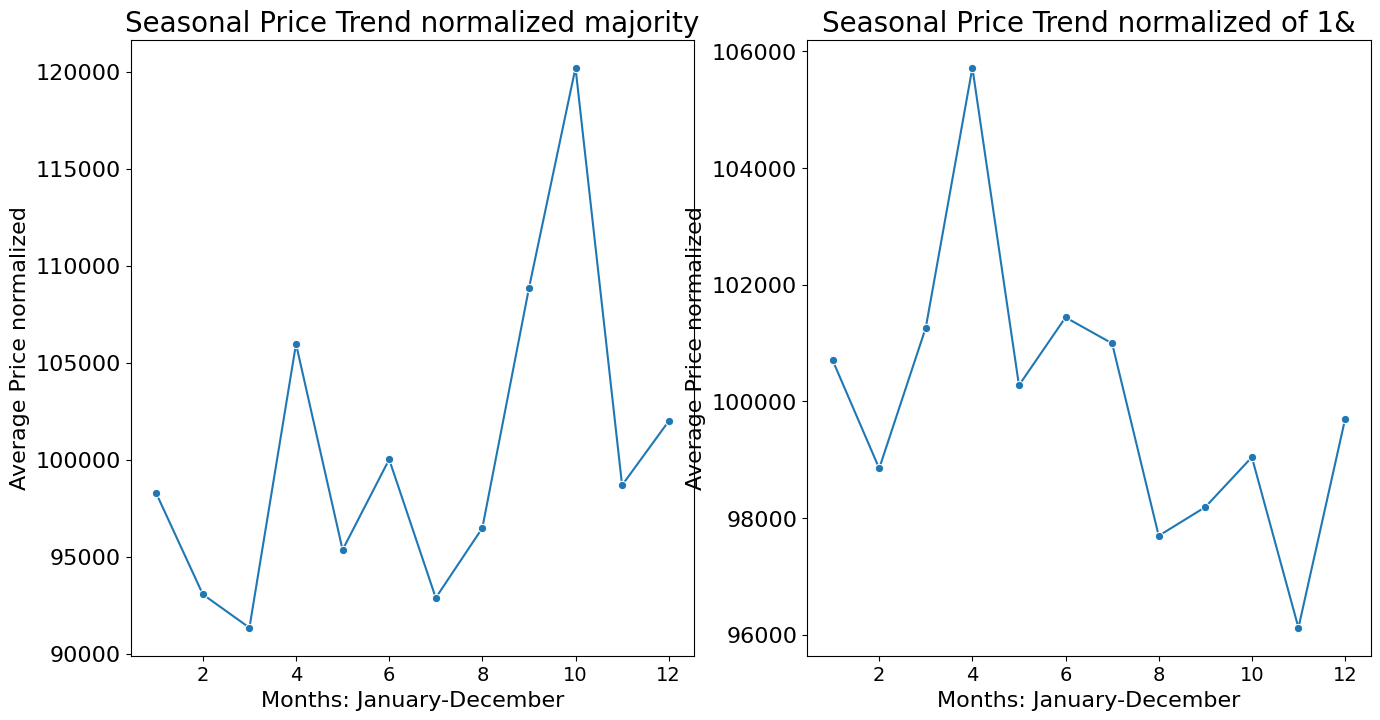

In [24]:
# Test for checking global difference, yes, its over normalized
fig, axes = plt.subplots(1,2, figsize=(16,8))


sns.lineplot(data=df_result_zip_norm_rich, x='month', y='normalized_price', marker='o',ax=axes[0])
axes[0].set_xlabel('Months: January-December')
axes[0].set_ylabel('Average Price normalized')
axes[0].set_title('Seasonal Price Trend normalized majority')


sns.lineplot(data=df_result_zip_norm_maj, x='month', y='normalized_price', marker='o',ax=axes[1])
axes[1].set_xlabel('Months: January-December')
axes[1].set_ylabel('Average Price normalized')
axes[1].set_title('Seasonal Price Trend normalized of 1&')

plt.savefig('data/months_normalized_zipcoded.png', dpi=300, bbox_inches='tight')

df_result_zip_rich

In [25]:
df_result_zip_maj

,zipcode,month,price
0,98001,1,278641.0
1,98001,2,292197.0
2,98001,3,266790.0
3,98001,4,335834.0
4,98001,5,253686.0
...,...,...,...
832,98199,8,780865.0
833,98199,9,786604.0
834,98199,10,743055.0
835,98199,11,662598.0


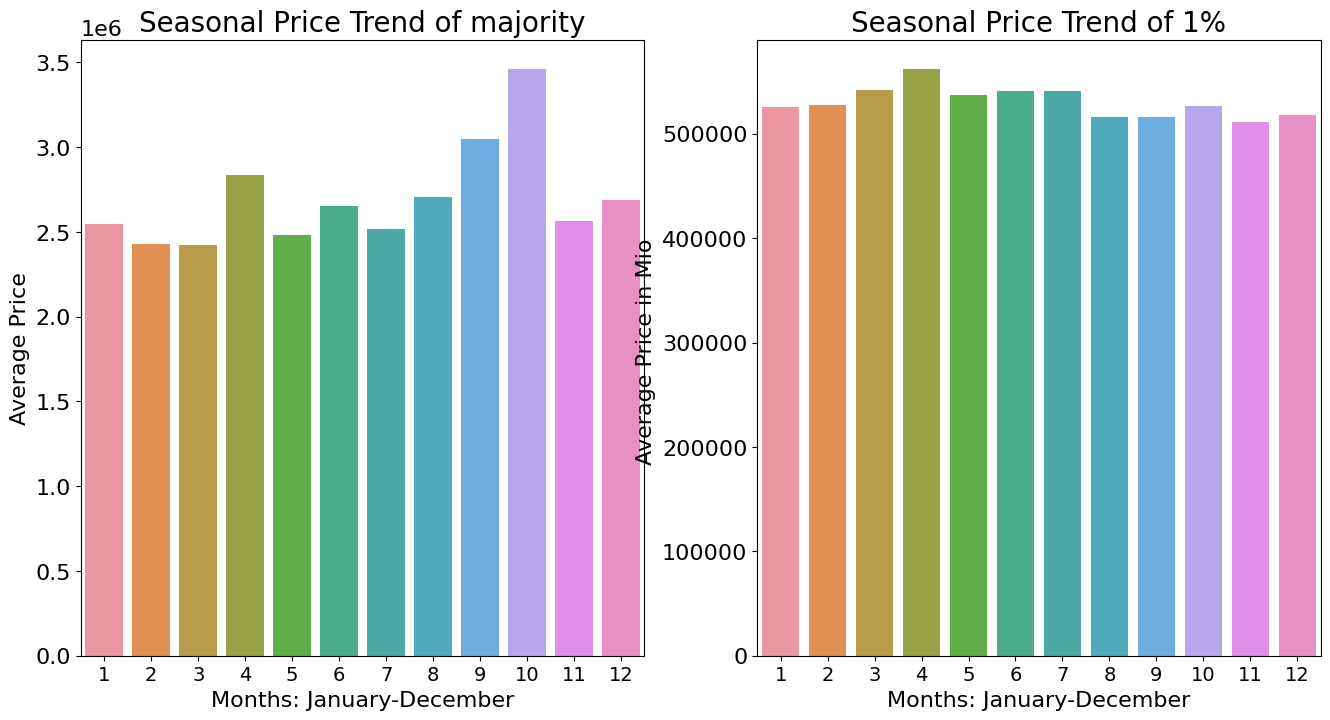

In [26]:
df_result_zip_rich = df_result_zip_rich.groupby('month')['price'].mean().reset_index()
df_result_zip_maj = df_result_zip_maj.groupby('month')['price'].mean().reset_index()

fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.barplot(data=df_result_zip_rich, x='month', y='price',ax=axes[0])
axes[0].set_xlabel('Months: January-December')
axes[0].set_ylabel('Average Price')
axes[0].set_title('Seasonal Price Trend of majority')

sns.barplot(data=df_result_zip_maj, x='month', y='price',ax=axes[1])
axes[1].set_xlabel('Months: January-December')
axes[1].set_ylabel('Average Price in Mio ')
axes[1].set_title('Seasonal Price Trend of 1%')


plt.savefig('data/months_zipcoded.png', dpi=300, bbox_inches='tight')

/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.v

Text(0.5, 1.0, 'Seasonal Price Trend normalized')

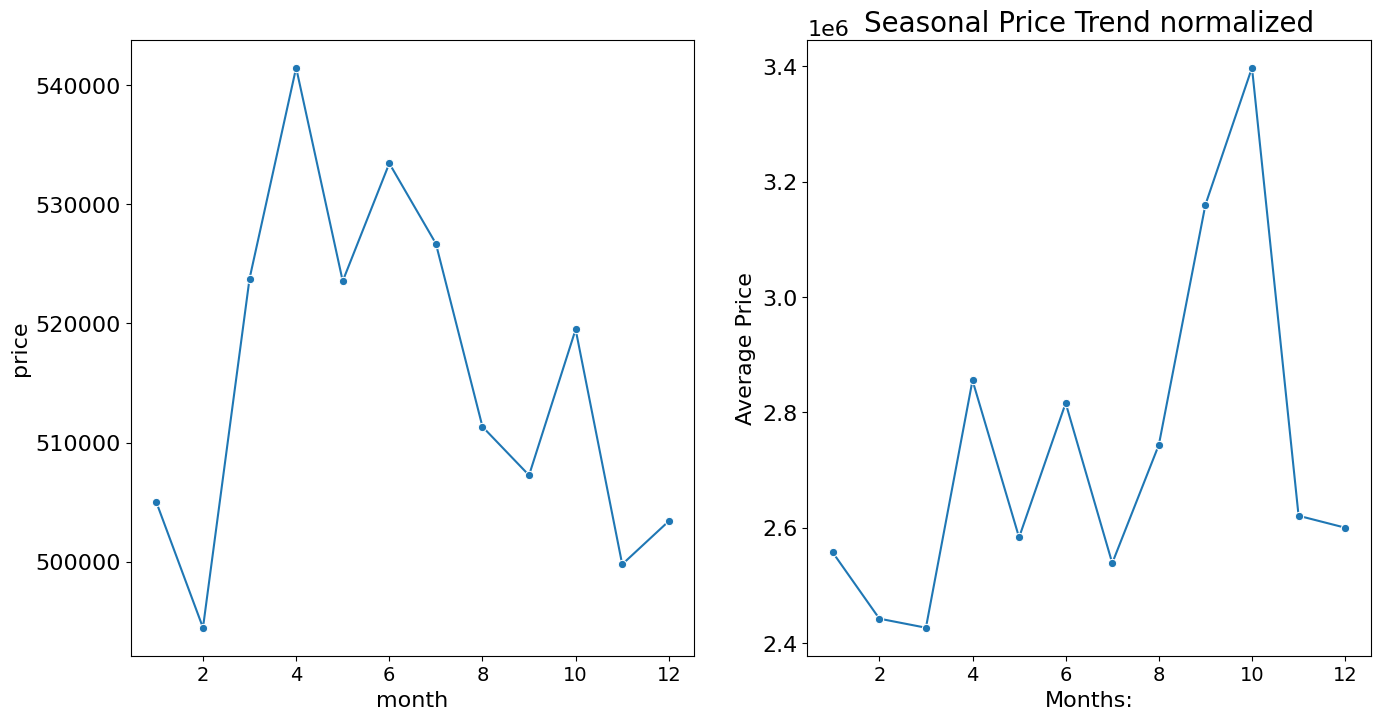

In [33]:

fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.lineplot(data=df_result_rich, x='month', y='price', marker='o',ax=axes[1])
plt.xlabel('Months:')
plt.ylabel('Average Price')
plt.title('Seasonal Price Trend normalized of 1%')

sns.lineplot(data=df_result_maj, x='month', y='price', marker='o',ax=axes[0])
plt.xlabel('Months:')
plt.ylabel('Average Price')
plt.title('Seasonal Price Trend normalized')


/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Seasonal Price Trend normalized of 1%')

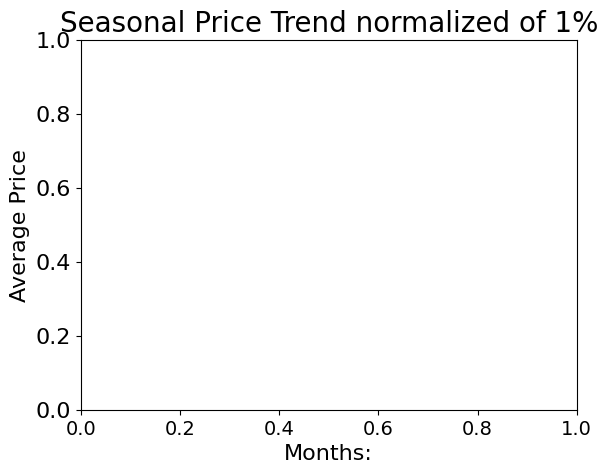

In [28]:
sns.lineplot(data=df_result_rich, x='month', y='price', marker='o',ax=axes[0])
plt.xlabel('Months:')
plt.ylabel('Average Price')
plt.title('Seasonal Price Trend normalized of 1%')

In [29]:
# from matplotlib.colors import Normalize
# from matplotlib.cm import get_cmap, ScalarMappable

# # Farbskala und Normalisierung
# norm = Normalize(vmin=df_result_zip_rich['price'].min(), vmax=df_result_zip_rich['price'].max())
# cmap = get_cmap('coolwarm')  # Blau-Rot-Verlauf

# # Farben für die Balken berechnen (als Liste)
# colors_rich = [cmap(norm(value)) for value in df_result_zip_rich['price']]
# colors_maj = [cmap(norm(value)) for value in df_result_zip_maj['price']]

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # Barplots mit Farbverlauf
# sns.barplot(data=df_result_zip_rich, x='month', y='price', ax=axes[0], palette=colors_rich)
# sns.barplot(data=df_result_zip_maj, x='month', y='price', ax=axes[1], palette=colors_maj)

# # Y-Achsen einschränken
# axes[0].set_ylim(400000, 600_000)
# axes[1].set_ylim(700000, 3_500_000)

# # Achsentitel und Diagrammtitel
# axes[0].set_title('Seasonal Price Trend of majority', fontweight='bold')
# axes[0].set_xlabel('Months: January-December')
# axes[0].set_ylabel('Average Price')

# axes[1].set_title('Seasonal Price Trend of 1%', fontweight='bold')
# axes[1].set_xlabel('Months: January-December')
# axes[1].set_ylabel('Average Price in Mio')

# # Farbskala hinzufügen
# sm = ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1, label='Price Scale')

# plt.tight_layout()
# plt.savefig('data/months_zipcoded_gradient_fixed.png', dpi=300, bbox_inches='tight')
# plt.show()


/tmp/ipykernel_69090/801474874.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_rich = get_cmap('coolwarm')  # Farbskala für Diagramm 1
/tmp/ipykernel_69090/801474874.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_maj = get_cmap('coolwarm')  # Farbskala für Diagramm 2


Text(0, 0.5, 'Avg Price in Mio')

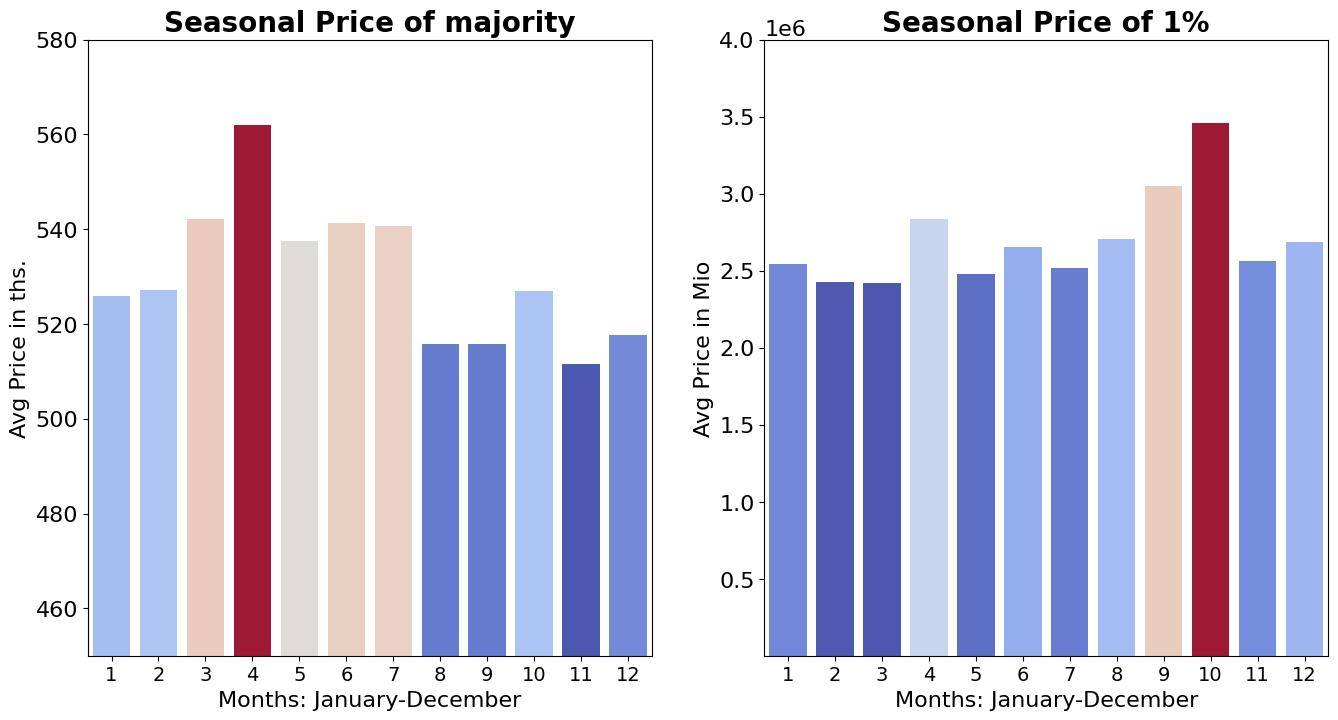

In [34]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable

df_maj_copy = df_result_zip_maj.copy()

# Preise in Millionen umrechnen (nur für Kopien)
df_maj_copy['price'] /= 1_000

# Farbskalen und Normalisierungen für beide Diagramme
norm_rich = Normalize(vmin=df_result_zip_rich['price'].min(), vmax=df_result_zip_rich['price'].max())
norm_maj = Normalize(vmin=df_maj_copy['price'].min(), vmax=df_maj_copy['price'].max())
cmap_rich = get_cmap('coolwarm')  # Farbskala für Diagramm 1
cmap_maj = get_cmap('coolwarm')  # Farbskala für Diagramm 2

# Farben für die Balken berechnen
colors_rich = [cmap_rich(norm_rich(value)) for value in df_result_zip_rich['price']]
colors_maj = [cmap_maj(norm_maj(value)) for value in df_maj_copy['price']]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=20)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=16)

# Barplots mit Farbverlauf
sns.barplot(data=df_result_zip_rich, x='month', y='price', ax=axes[1], palette=colors_rich)
sns.barplot(data=df_maj_copy, x='month', y='price', ax=axes[0], palette=colors_maj)

# Y-Achsen einschränken
axes[0].set_ylim(450, 580)
axes[1].set_ylim(1500, 4_000_000)  # Beispiel für höhere Werte im zweiten Diagramm

# Achsentitel und Diagrammtitel
axes[0].set_title('Seasonal Price of majority', fontweight='bold')
axes[0].set_xlabel('Months: January-December')
axes[0].set_ylabel('Avg Price in ths.')

axes[1].set_title('Seasonal Price of 1%', fontweight='bold')
axes[1].set_xlabel('Months: January-December')
axes[1].set_ylabel('Avg Price in Mio')


In [31]:
# df_result_zip_maj
# df_maj_copy = df_result_zip_maj.copy()

# # Preise in Millionen umrechnen (nur für Kopien)
# df_maj_copy['price'] /= 1_000
# df_result_zip_norm_rich

In [32]:
# # Gruppieren und Mittelwert berechnen
# df_result_zip_rich = df_result_zip_rich.groupby('month')['price'].mean().reset_index()
# df_result_zip_maj = df_result_zip_maj.groupby('month')['price'].mean().reset_index()

# # Kopien erstellen
# df_rich_copy = df_result_zip_rich.copy()
# df_maj_copy = df_result_zip_maj.copy()

# # Preise in Millionen umrechnen (nur für Kopien)
# df_maj_copy['price'] /= 1_000_000

# # Diagramme erstellen
# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # Barplot für majority
# sns.barplot(data=df_rich_copy, x='month', y='price', ax=axes[0])
# axes[0].set_xlabel('Months: January-December')
# axes[0].set_ylabel('Average Price')  # Originaleinheit bleibt erhalten
# axes[0].set_title('Seasonal Price Trend of majority')

# # Barplot für 1% (mit skalierten Preisen)
# sns.barplot(data=df_maj_copy, x='month', y='price', ax=axes[1])
# axes[1].set_xlabel('Months: January-December')
# axes[1].set_ylabel('Average Price in Mio')  # Beschriftung angepasst
# axes[1].set_title('Seasonal Price Trend of 1%')

# # Plot speichern und anzeigen
# plt.tight_layout()
# plt.savefig('data/months_zipcoded_mio_fixed.png', dpi=300, bbox_inches='tight')
# plt.show()
